# New Tools for Pneumonia Diagnosis

## Lydia Cuffman, Bobby Gerberick, Nick Tjandra


## Overview

Pneumonia is a very serious illness that can lead to dire health outcomes including death. Proper diagnosis is the first step in the process of successful treatment. Pneumonia is most often diagnosed by expert evaluation of a chest x-ray. In some healthcare settings, the number of potential pneumonia cases outpaces the capacity of trained personnel to review them. We have built a model as a first evaluator, which provides an overworked healthcare worker with fewer x-rays to evaluate without having to worry about failing to catch a pneumonia case.

## Business Problem

Pneumonia is a leading cause of death among children under five, so it is of vital importance to healthcare systems and their patients that pneumonia is quickly and accurately diagnosed. In some settings there are more possible cases than there is time to evaluate them. For these clinics and hospitals, it would be very valuable to reduce that human workload, if that could be done without missing true cases of childhood pneumonia. If the first look could be automated, that would allow the experts an opportunity to direct their expertise towards other pressing medical concerns.

We developed a model that takes in an x-ray of child's lungs and predicts whether they have pneumonia. A false positive would be saying they do when they don't. A false negative would mean saying a child does not have pneumonia when they actually do. In this setting, a false positive is acceptable while a false negative is close to intolerable. False positives mean the healthcare worker has to examine a few extra x-rays. Considering the alternative is looking at ALL of the x-rays, this is still a major improvement. A false negative means a child does not receive appropriate treatment for a serious disease, which is a much bigger issue. Our model prioritizes recall above all else.

We did not optimize for recall exclusively however, because that would be essentially the system as it currently exists: assume everyone has pneumonia and check for where you're wrong. Instead, we designed a model that sought to optimize for both recall and accuracy, and then selected the model with the highest recall score.

As the x-rays were going to be further examined by a medical professional, our model did not need to be easily interpretable. In any marginal cases the final call would be made by a doctor or other expert, so a black box model was not an issue, especially if such a model increased recall scores. Additionally, images are not suited to transparent models anyway, so a somewhat mysterious model was unavoidable.


## Data Understanding

Our data set is a collection of x-rays of children's lungs found at https://data.mendeley.com/datasets/rscbjbr9sj/3, collected through collaboration of the University of California, San Diego and Guangzhou Women and Children's Medical Center. Several different data sets are available at that link. We focused exclusively on the chest x-rays. As chest x-rays are the primary method of diagnosing pneumonia, these images are obviously relevant to our question. The target variable for our analysis is "pneumonia" vs. "normal." The images are already sorted into training, testing, and validation sets. The validation set was insufficiently sized for our purposes so we ignored it, instead creating a validation set within the training set.

In [1]:
#Necessary imports
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.models import load_model
import seaborn as sns

In [2]:
#Prepare the data, rescaling images and creating a validation set
train_data_dir = 'data/localdata/chest_xray/train'
test_data_dir = 'data/localdata/chest_xray/test'

generator =ImageDataGenerator(rescale=1/255, validation_split=.25)

train_generator= generator.flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=32, color_mode='grayscale', subset='training', class_mode='binary')
validation_set=generator.flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=32, color_mode='grayscale', subset='validation', class_mode='binary')
test_generator = generator.flow_from_directory(
        test_data_dir, target_size=(64, 64), batch_size=32, color_mode='grayscale', class_mode='binary', shuffle=False)

train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(validation_set)

Found 6280 images belonging to 2 classes.
Found 2092 images belonging to 2 classes.
Found 1140 images belonging to 2 classes.


In [3]:
#Build a function that visualizes our model results
def plot_loss_recall_and_accuracy(results, final=False):
    
    if final:
        val_label="test"
    else:
        val_label="validation"

    # Extracting metrics from model fitting
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_recall = results.history['recall']
    val_recall = results.history['val_recall']
    train_accuracy = results.history['binary_accuracy']
    val_accuracy = results.history['val_binary_accuracy']

    # Setting up plots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15))

    # Plotting loss info
    ax1.set_title("Loss")
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label="train")
    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label=val_label)
    ax1.legend()

    #Plotting precision
    ax2.set_title("Recall")
    sns.lineplot(x=results.epoch, y=train_recall, ax=ax2, label="train")
    sns.lineplot(x=results.epoch, y=val_recall, ax=ax2, label=val_label)
    ax2.legend()
    
    # Plotting accuracy info
    ax3.set_title("Accuracy")
    sns.lineplot(x=results.epoch, y=train_accuracy, ax=ax3, label="train")
    sns.lineplot(x=results.epoch, y=val_accuracy, ax=ax3, label=val_label)
    ax3.legend()

#this function was adapted from Flatiron instructional materials

## Modeling

As a baseline, we designed a dummy model that always predicted pneumonia. It had a perfect recall score, but an accuracy of 75%. Further iterations would attempt to raise the accuracy score with minimal compromise of recall. We wanted the model to work better but without missing true pneumonia cases.

We then began iterating to see what adjustments improved both scores, but especially recall. We experimented with adding convolutional layers, adjusting the learning rate both up and down, adding image augmentation to our training data, regularizing with a dropout layer, and various combinations of these adjustments.

Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 0.3309 - recall: 0.9918 - binary_accuracy: 0.8529
Epoch 00001: val_recall improved from -inf to 0.99772, saving model to simple_model.h5
197/197 [==============================] - 93s 473ms/step - loss: 0.3309 - recall: 0.9918 - binary_accuracy: 0.8529 - val_loss: 0.2350 - val_recall: 0.9977 - val_binary_accuracy: 0.8838
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 0.2279 - recall: 0.9943 - binary_accuracy: 0.9191
Epoch 00002: val_recall did not improve from 0.99772
197/197 [==============================] - 90s 458ms/step - loss: 0.2279 - recall: 0.9943 - binary_accuracy: 0.9191 - val_loss: 0.1823 - val_recall: 0.9937 - val_binary_accuracy: 0.9402
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.2020 - recall: 0.9888 - binary_accuracy: 0.9349
Epoch 00003: val_recall did not improve from 0.99772
197/197 [==============================] - 94s 476ms/step - loss: 0.2020 - 

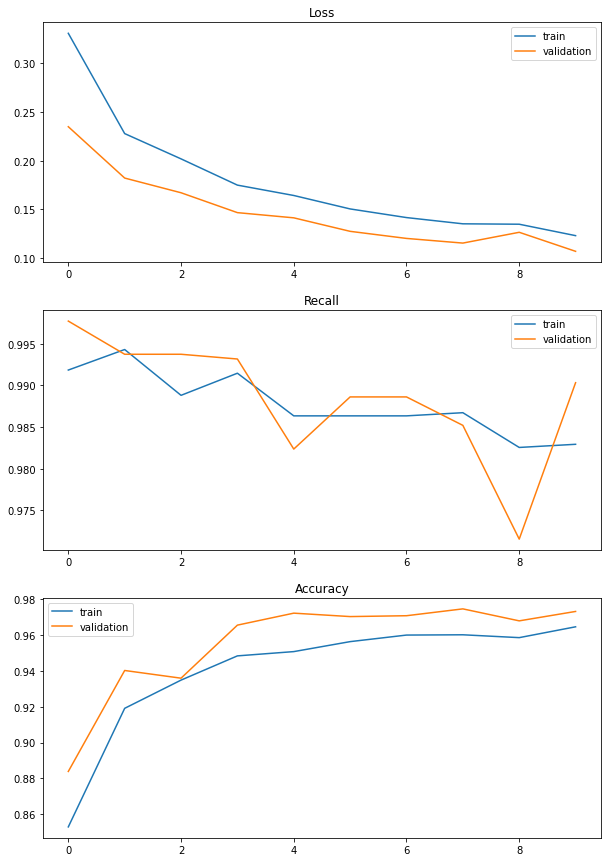

In [4]:
#We begin the process with a simple dense neural network.
simple_model = models.Sequential()
simple_model.add(layers.Flatten())
simple_model.add(Dense(12, activation='relu'))
simple_model.add(Dense(1, activation='sigmoid'))

simple_model.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
              metrics=['Recall', 'BinaryAccuracy'])
model_check = ModelCheckpoint('simple_model.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

results = simple_model.fit(train_generator, epochs=10, validation_data=validation_set, callbacks=[model_check])
plot_loss_recall_and_accuracy(results)


Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 0.2309 - recall: 0.9820 - binary_accuracy: 0.9105
Epoch 00001: val_recall improved from -inf to 0.96587, saving model to model2.h5
197/197 [==============================] - 104s 529ms/step - loss: 0.2309 - recall: 0.9820 - binary_accuracy: 0.9105 - val_loss: 0.1064 - val_recall: 0.9659 - val_binary_accuracy: 0.9646
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 0.0975 - recall: 0.9845 - binary_accuracy: 0.9635
Epoch 00002: val_recall did not improve from 0.96587
197/197 [==============================] - 110s 560ms/step - loss: 0.0975 - recall: 0.9845 - binary_accuracy: 0.9635 - val_loss: 0.1185 - val_recall: 0.9568 - val_binary_accuracy: 0.9598
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.0724 - recall: 0.9886 - binary_accuracy: 0.9742
Epoch 00003: val_recall improved from 0.96587 to 0.99147, saving model to model2.h5
197/197 [==============================] - 108s 

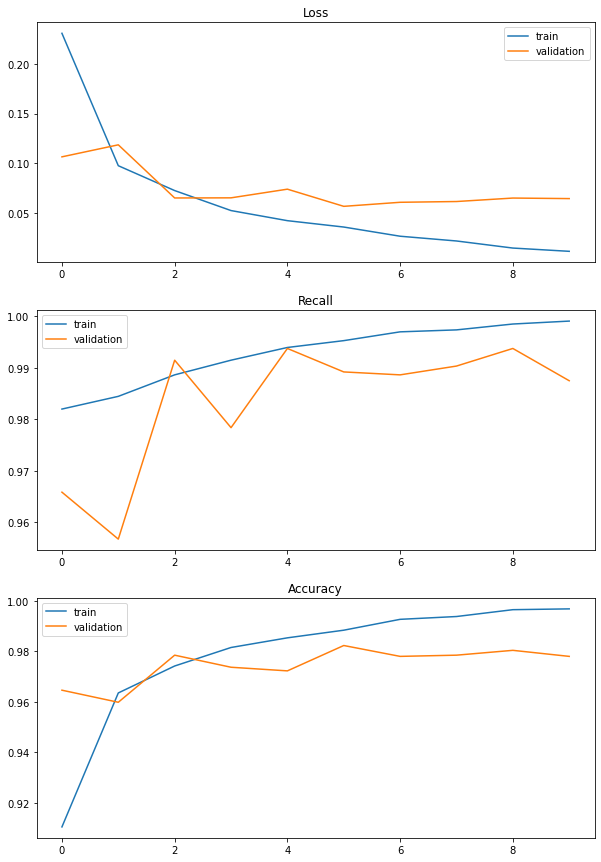

In [5]:
#Now we add a convolutional layer, a very useful tool in many image classification models.
model2 = models.Sequential()
model2.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 1)))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
               metrics=['Recall', 'BinaryAccuracy'])
model_check = ModelCheckpoint('model2.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

results2 = model2.fit(train_generator, epochs=10, validation_data=validation_set, callbacks=[model_check])
plot_loss_recall_and_accuracy(results2)


Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 0.2130 - recall: 0.9735 - binary_accuracy: 0.9140
Epoch 00001: val_recall improved from -inf to 0.99772, saving model to model3.h5
197/197 [==============================] - 103s 525ms/step - loss: 0.2130 - recall: 0.9735 - binary_accuracy: 0.9140 - val_loss: 0.1893 - val_recall: 0.9977 - val_binary_accuracy: 0.9216
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 0.1120 - recall: 0.9755 - binary_accuracy: 0.9551
Epoch 00002: val_recall did not improve from 0.99772
197/197 [==============================] - 102s 518ms/step - loss: 0.1120 - recall: 0.9755 - binary_accuracy: 0.9551 - val_loss: 0.0732 - val_recall: 0.9767 - val_binary_accuracy: 0.9728
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.0819 - recall: 0.9826 - binary_accuracy: 0.9688
Epoch 00003: val_recall did not improve from 0.99772
197/197 [==============================] - 101s 510ms/step - loss: 0.0819 - rec

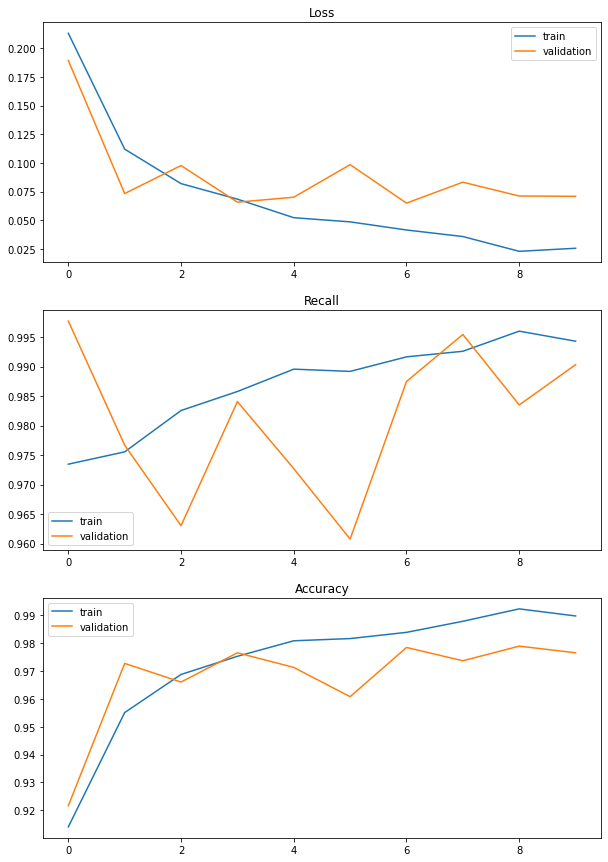

In [9]:
#We added another level to see if added complexity improved our model
model3 = models.Sequential()
model3.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 1)))
model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
                metrics=['Recall', 'BinaryAccuracy'])

model_check = ModelCheckpoint('model3.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

results3 = model3.fit(train_generator, epochs=10, validation_data=validation_set, callbacks=[model_check])
plot_loss_recall_and_accuracy(results3)



In [10]:
#Raise the resolution of the images to see if it improves outcomes
generator_big =ImageDataGenerator(rescale=1/255, validation_split=.25)

train_generator_big= generator_big.flow_from_directory(
        train_data_dir, target_size=(300, 300), batch_size=32, color_mode='grayscale', subset='training', class_mode='binary')
validation_set_big=generator_big.flow_from_directory(
        train_data_dir, target_size=(300, 300), batch_size=32, color_mode='grayscale', subset='validation', class_mode='binary')
test_generator_big= generator_big.flow_from_directory(
        test_data_dir, target_size=(300, 300), batch_size=32, color_mode='grayscale', class_mode='binary', shuffle=False)

train_images_big, train_labels_big = next(train_generator_big)
test_images_big, test_labels_big = next(test_generator_big)
val_images_big, val_labels_big = next(validation_set_big)

Found 6280 images belonging to 2 classes.
Found 2092 images belonging to 2 classes.
Found 1140 images belonging to 2 classes.


Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 0.5229 - recall: 0.9592 - binary_accuracy: 0.9194
Epoch 00001: val_recall improved from -inf to 0.97554, saving model to model4.h5
197/197 [==============================] - 296s 2s/step - loss: 0.5229 - recall: 0.9592 - binary_accuracy: 0.9194 - val_loss: 0.0764 - val_recall: 0.9755 - val_binary_accuracy: 0.9747
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 0.0453 - recall: 0.9937 - binary_accuracy: 0.9855
Epoch 00002: val_recall improved from 0.97554 to 0.97668, saving model to model4.h5
197/197 [==============================] - 305s 2s/step - loss: 0.0453 - recall: 0.9937 - binary_accuracy: 0.9855 - val_loss: 0.0728 - val_recall: 0.9767 - val_binary_accuracy: 0.9771
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.0180 - recall: 0.9977 - binary_accuracy: 0.9959
Epoch 00003: val_recall improved from 0.97668 to 0.98294, saving model to model4.h5
197/197 [==============

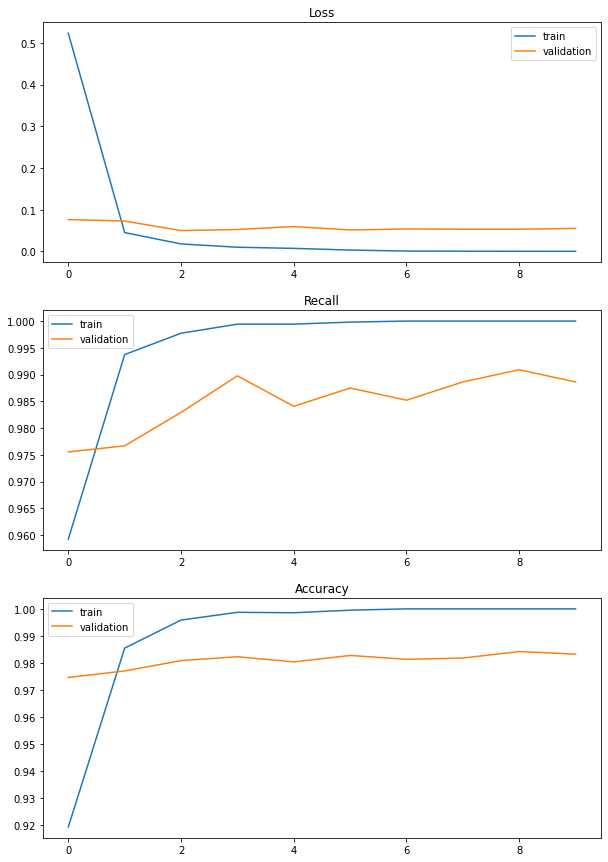

In [11]:
#Model with higher resolution scans as input
model4 = models.Sequential()
model4.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(300, 300, 1)))
model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(64, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))

model4.compile(optimizer="Adam",
              loss='BinaryCrossentropy',
                metrics=['Recall', 'BinaryAccuracy'])

model_check = ModelCheckpoint('model4.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

results4 = model4.fit(train_generator_big, epochs=10, validation_data=validation_set_big,
                    callbacks=[model_check])
plot_loss_recall_and_accuracy(results4)

Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 803.2455 - recall: 0.8707 - binary_accuracy: 0.7561
Epoch 00001: val_recall improved from -inf to 1.00000, saving model to model5.h5
197/197 [==============================] - 96s 485ms/step - loss: 803.2455 - recall: 0.8707 - binary_accuracy: 0.7561 - val_loss: 0.4707 - val_recall: 1.0000 - val_binary_accuracy: 0.8403
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 0.5862 - recall: 0.9439 - binary_accuracy: 0.8018
Epoch 00002: val_recall did not improve from 1.00000
197/197 [==============================] - 108s 549ms/step - loss: 0.5862 - recall: 0.9439 - binary_accuracy: 0.8018 - val_loss: 0.8537 - val_recall: 0.0000e+00 - val_binary_accuracy: 0.1597
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.5021 - recall: 0.9894 - binary_accuracy: 0.8323
Epoch 00003: val_recall did not improve from 1.00000
197/197 [==============================] - 93s 472ms/step - loss: 0.5021

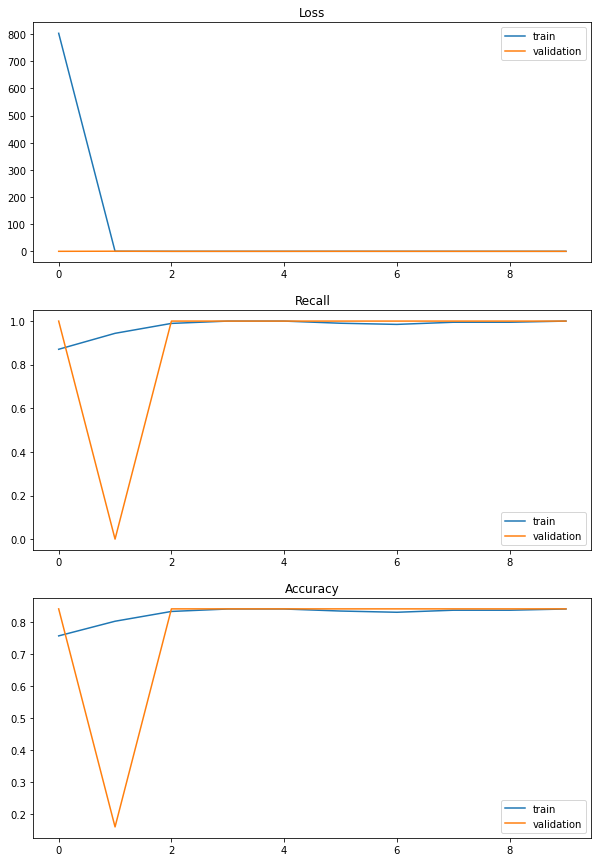

In [13]:
#That didn't help and it took longer, so let's go back to lower resolution images
#Learning rate is a very tunable parameter, so we'll see what happens when we raise that.
model5 = models.Sequential()
model5.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 1)))
model5.add(layers.MaxPooling2D(pool_size=(2, 2)))
model5.add(layers.Flatten())
model5.add(layers.Dense(64, activation='relu'))
model5.add(layers.Dense(1, activation='sigmoid'))

model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1),
              loss='BinaryCrossentropy',
                metrics=['Recall', 'BinaryAccuracy'])

model_check = ModelCheckpoint('model5.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

results5 = model5.fit(train_generator, epochs=10, validation_data=validation_set,
                    callbacks=[model_check])
plot_loss_recall_and_accuracy(results5)


Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 4.7620 - recall: 0.9896 - binary_accuracy: 0.8326
Epoch 00001: val_recall improved from -inf to 1.00000, saving model to model6.h5
197/197 [==============================] - 101s 512ms/step - loss: 4.7620 - recall: 0.9896 - binary_accuracy: 0.8326 - val_loss: 0.4393 - val_recall: 1.0000 - val_binary_accuracy: 0.8403
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 0.4440 - recall: 1.0000 - binary_accuracy: 0.8400
Epoch 00002: val_recall did not improve from 1.00000
197/197 [==============================] - 106s 537ms/step - loss: 0.4440 - recall: 1.0000 - binary_accuracy: 0.8400 - val_loss: 0.4403 - val_recall: 1.0000 - val_binary_accuracy: 0.8403
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.4426 - recall: 1.0000 - binary_accuracy: 0.8400
Epoch 00003: val_recall did not improve from 1.00000
197/197 [==============================] - 107s 542ms/step - loss: 0.4426 - rec

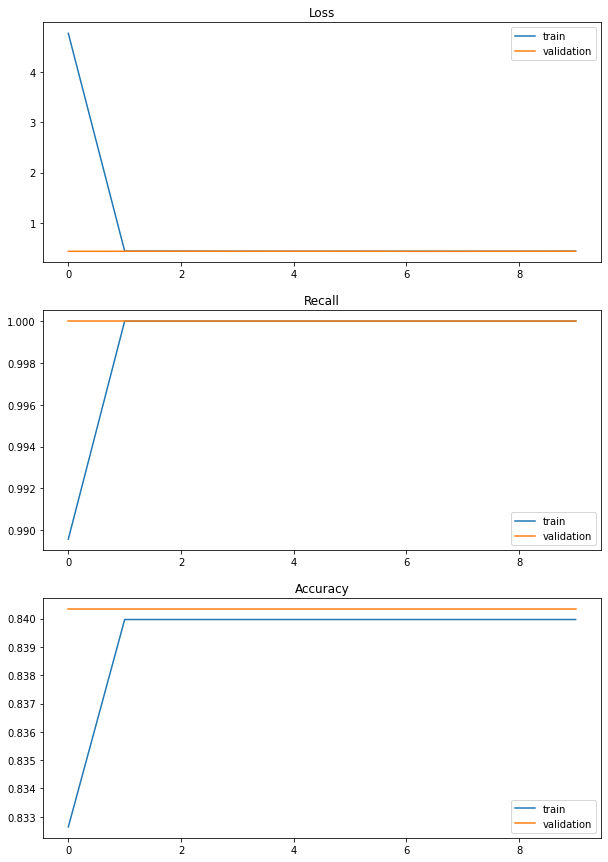

In [14]:
#Perfect recall is great, but it seems that's at the expense of any kind of useful accuracy.
#We tried a lower rate.
model6 = models.Sequential()
model6.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 1)))
model6.add(layers.MaxPooling2D(pool_size=(2, 2)))
model6.add(layers.Flatten())
model6.add(layers.Dense(64, activation='relu'))
model6.add(layers.Dense(1, activation='sigmoid'))

model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.1),
              loss='BinaryCrossentropy',
              metrics=['Recall', 'BinaryAccuracy'])

model_check = ModelCheckpoint('model6.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

results6 = model6.fit(train_generator, epochs=10, validation_data=validation_set,
                    callbacks=[model_check])
plot_loss_recall_and_accuracy(results6)


Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 0.4122 - recall: 0.9689 - binary_accuracy: 0.9038
Epoch 00001: val_recall improved from -inf to 0.97782, saving model to model7.h5
197/197 [==============================] - 108s 546ms/step - loss: 0.4122 - recall: 0.9689 - binary_accuracy: 0.9038 - val_loss: 0.0811 - val_recall: 0.9778 - val_binary_accuracy: 0.9661
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 0.1044 - recall: 0.9818 - binary_accuracy: 0.9621
Epoch 00002: val_recall did not improve from 0.97782
197/197 [==============================] - 103s 525ms/step - loss: 0.1044 - recall: 0.9818 - binary_accuracy: 0.9621 - val_loss: 0.1036 - val_recall: 0.9659 - val_binary_accuracy: 0.9646
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.0872 - recall: 0.9827 - binary_accuracy: 0.9662
Epoch 00003: val_recall improved from 0.97782 to 0.98237, saving model to model7.h5
197/197 [==============================] - 104s 

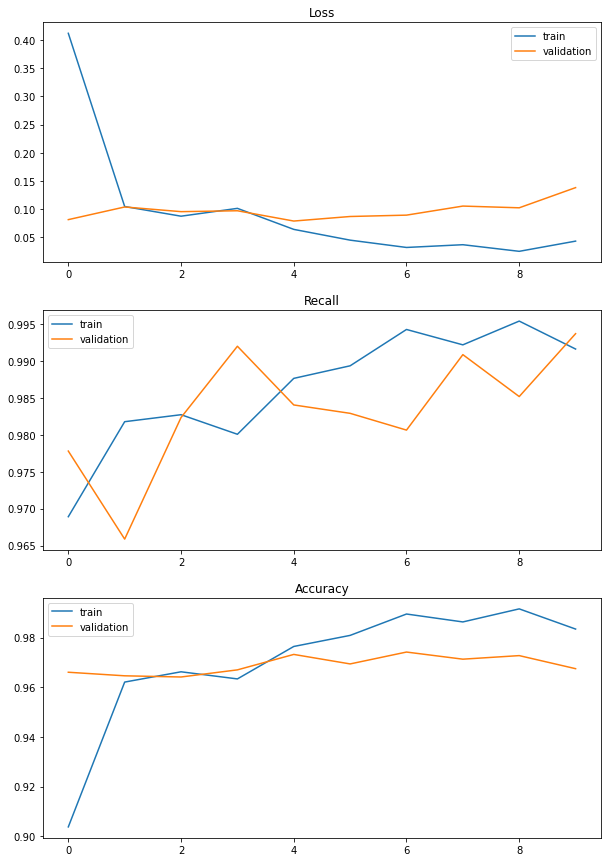

In [15]:
#That model had the same issues as model5, so we brought it down again, but still higher than the original learning rate.
model7 = models.Sequential()
model7.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 1)))
model7.add(layers.MaxPooling2D(pool_size=(2, 2)))
model7.add(layers.Flatten())
model7.add(layers.Dense(64, activation='relu'))
model7.add(layers.Dense(1, activation='sigmoid'))

model7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.01),
              loss='BinaryCrossentropy',
              metrics=['Recall', 'BinaryAccuracy'])

model_check = ModelCheckpoint('model7.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

results7 = model7.fit(train_generator, epochs=10, validation_data=validation_set,
                    callbacks=[model_check])
plot_loss_recall_and_accuracy(results7)



Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 0.3201 - recall: 0.9970 - binary_accuracy: 0.8704
Epoch 00001: val_recall improved from -inf to 0.99147, saving model to model8.h5
197/197 [==============================] - 108s 549ms/step - loss: 0.3201 - recall: 0.9970 - binary_accuracy: 0.8704 - val_loss: 0.1833 - val_recall: 0.9915 - val_binary_accuracy: 0.9398
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 0.1702 - recall: 0.9854 - binary_accuracy: 0.9396
Epoch 00002: val_recall did not improve from 0.99147
197/197 [==============================] - 107s 543ms/step - loss: 0.1702 - recall: 0.9854 - binary_accuracy: 0.9396 - val_loss: 0.1314 - val_recall: 0.9767 - val_binary_accuracy: 0.9670
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.1249 - recall: 0.9852 - binary_accuracy: 0.9578
Epoch 00003: val_recall improved from 0.99147 to 0.99431, saving model to model8.h5
197/197 [==============================] - 106s 

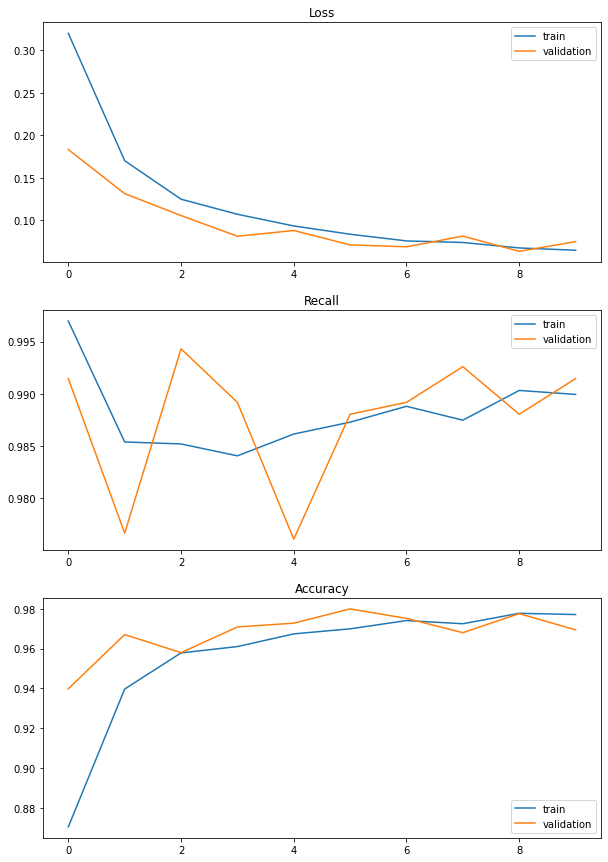

In [16]:
#Higher learning rates didn't seem to help much, so we also tried a lower than default rate
model8 = models.Sequential()
model8.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 1)))
model8.add(layers.MaxPooling2D(pool_size=(2, 2)))
model8.add(layers.Flatten())
model8.add(layers.Dense(64, activation='relu'))
model8.add(layers.Dense(1, activation='sigmoid'))

model8.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
              loss='BinaryCrossentropy',
              metrics=['Recall', 'BinaryAccuracy'])

model_check = ModelCheckpoint('model8.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

results8 = model8.fit(train_generator, epochs=10, validation_data=validation_set,
                    callbacks=[model_check])
plot_loss_recall_and_accuracy(results8)


Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 0.2006 - recall: 0.9805 - binary_accuracy: 0.9225
Epoch 00001: val_recall improved from -inf to 0.99317, saving model to model9.h5
197/197 [==============================] - 109s 554ms/step - loss: 0.2006 - recall: 0.9805 - binary_accuracy: 0.9225 - val_loss: 0.0853 - val_recall: 0.9932 - val_binary_accuracy: 0.9713
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 0.0904 - recall: 0.9869 - binary_accuracy: 0.9701
Epoch 00002: val_recall did not improve from 0.99317
197/197 [==============================] - 105s 535ms/step - loss: 0.0904 - recall: 0.9869 - binary_accuracy: 0.9701 - val_loss: 0.0672 - val_recall: 0.9869 - val_binary_accuracy: 0.9766
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.0743 - recall: 0.9884 - binary_accuracy: 0.9747
Epoch 00003: val_recall did not improve from 0.99317
197/197 [==============================] - 104s 527ms/step - loss: 0.0743 - rec

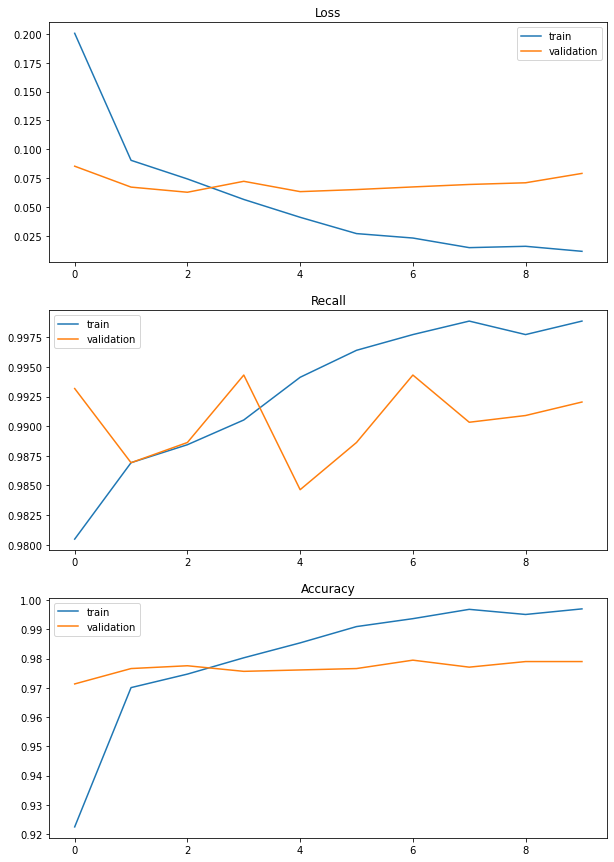

In [17]:
#Learning rates near the default seemed to help just a bit, but since it helped in both directions, it's not clear
#how to use those to effectively tune our model.
#Another tweak we want to try is a dropout layer to see if some regularization makes the model more generalizable,
#which would improve our validation scores.
model9 = models.Sequential()
model9.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 1)))
model9.add(layers.MaxPooling2D(pool_size=(2, 2)))
model9.add(layers.Flatten())
model9.add(layers.Dropout(0.1))
model9.add(layers.Dense(64, activation='relu'))
model9.add(layers.Dense(1, activation='sigmoid'))

model9.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
              metrics=['Recall', 'BinaryAccuracy'])

model_check = ModelCheckpoint('model9.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

results9 = model9.fit(train_generator, epochs=10, validation_data=validation_set,
                    callbacks=[model_check])
plot_loss_recall_and_accuracy(results9)


In [18]:
#We reprocessed our images to try some image augmentation.

train_data_dir = 'data/localdata/chest_xray/train'
test_data_dir = 'data/localdata/chest_xray/test'

generator2 = ImageDataGenerator(rescale=1/255, validation_split=0.25,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

train_generator2= generator2.flow_from_directory(
        train_data_dir, target_size=(64, 64), batch_size=32, color_mode='grayscale', subset='training', class_mode='binary', seed=2)


train_images2, train_labels2 = next(train_generator2)


Found 6280 images belonging to 2 classes.


Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 0.4314 - recall: 0.9900 - binary_accuracy: 0.8414
Epoch 00001: val_recall improved from -inf to 0.94539, saving model to model10.h5
197/197 [==============================] - 101s 511ms/step - loss: 0.4314 - recall: 0.9900 - binary_accuracy: 0.8414 - val_loss: 0.2613 - val_recall: 0.9454 - val_binary_accuracy: 0.8996
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 0.3080 - recall: 0.9644 - binary_accuracy: 0.8701
Epoch 00002: val_recall did not improve from 0.94539
197/197 [==============================] - 99s 501ms/step - loss: 0.3080 - recall: 0.9644 - binary_accuracy: 0.8701 - val_loss: 0.2605 - val_recall: 0.8703 - val_binary_accuracy: 0.8872
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.2581 - recall: 0.9608 - binary_accuracy: 0.8890
Epoch 00003: val_recall did not improve from 0.94539
197/197 [==============================] - 103s 523ms/step - loss: 0.2581 - rec

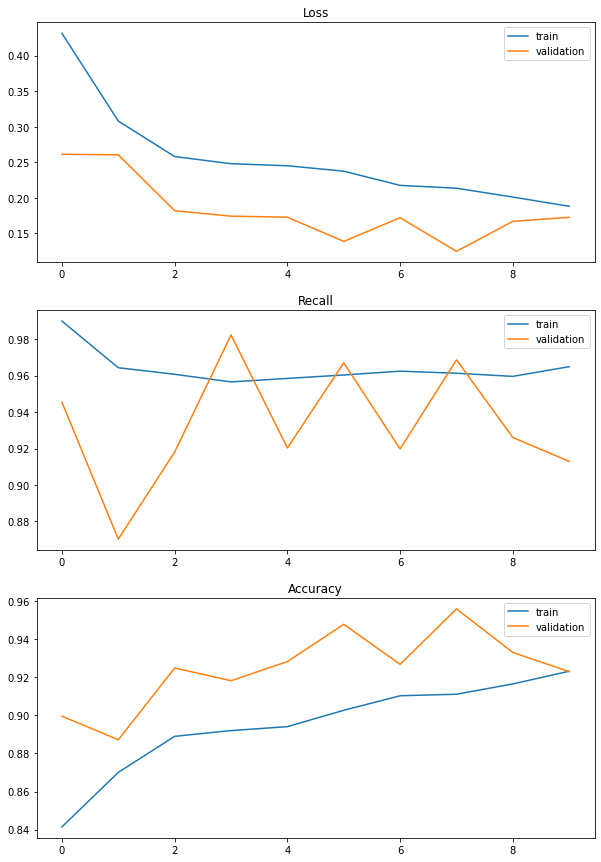

In [20]:
#Trying a model with the augmented images
model10 = models.Sequential()
model10.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 1)))
model10.add(layers.MaxPooling2D(pool_size=(2, 2)))
model10.add(layers.Flatten())
model10.add(layers.Dropout(0.1))
model10.add(layers.Dense(64, activation='relu'))
model10.add(layers.Dense(1, activation='sigmoid'))

model10.compile(optimizer='Adam',
                loss='BinaryCrossentropy', 
                metrics=['Recall', 'BinaryAccuracy'])

model_check = ModelCheckpoint('model10.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

results10 = model10.fit(train_generator2, epochs=10, validation_data=validation_set,
                    callbacks=[model_check])
plot_loss_recall_and_accuracy(results10)


Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 0.2581 - recall: 0.9731 - binary_accuracy: 0.8982
Epoch 00001: val_recall improved from -inf to 0.97497, saving model to model11.h5
197/197 [==============================] - 106s 538ms/step - loss: 0.2581 - recall: 0.9731 - binary_accuracy: 0.8982 - val_loss: 0.1144 - val_recall: 0.9750 - val_binary_accuracy: 0.9665
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 0.1015 - recall: 0.9803 - binary_accuracy: 0.9621
Epoch 00002: val_recall improved from 0.97497 to 0.98635, saving model to model11.h5
197/197 [==============================] - 126s 641ms/step - loss: 0.1015 - recall: 0.9803 - binary_accuracy: 0.9621 - val_loss: 0.0679 - val_recall: 0.9863 - val_binary_accuracy: 0.9737
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.0744 - recall: 0.9848 - binary_accuracy: 0.9713
Epoch 00003: val_recall improved from 0.98635 to 0.99317, saving model to model11.h5
197/197 [=====

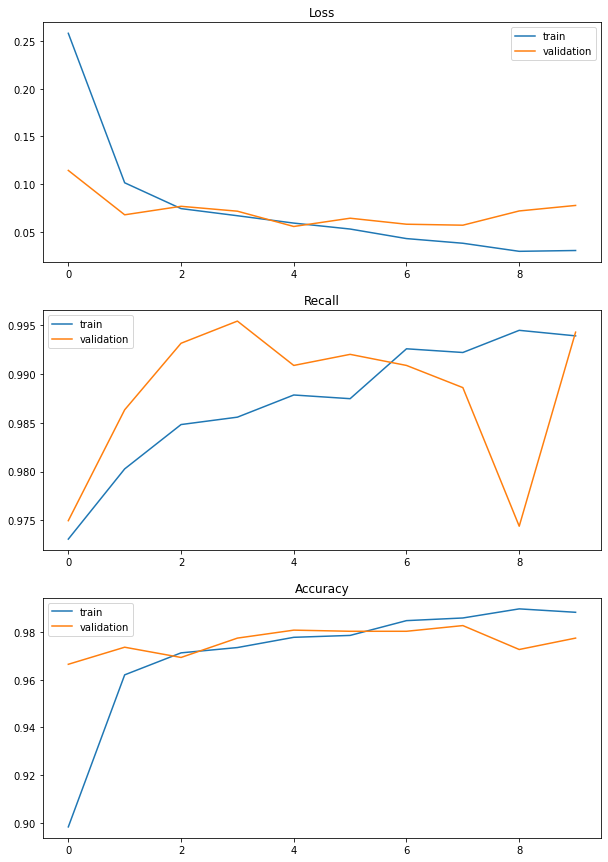

In [33]:
#Image augmentation didn't seem to help much, so we discarded that too. Looking at our models thus far,
#our multi-layer CNN and our dropout model both have very promising scores. So we made a multi-layer CNN
#with a dropout layer.
model11 = models.Sequential()
model11.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(64, 64, 1)))
model11.add(layers.MaxPooling2D(pool_size=(2, 2)))
model11.add(layers.Conv2D(64, (3, 3), activation='relu'))
model11.add(layers.MaxPooling2D((2, 2)))
model11.add(layers.Conv2D(64, (3, 3), activation='relu'))
model11.add(layers.Flatten())
model11.add(layers.Dropout(0.1))
model11.add(layers.Dense(64, activation='relu'))
model11.add(layers.Dense(1, activation='sigmoid'))

model11.compile(optimizer='Adam',
              loss='BinaryCrossentropy',
                metrics=['Recall', 'BinaryAccuracy'])

model_check = ModelCheckpoint('model11.h5', monitor='val_recall', mode='max', verbose=1, save_best_only=True)

results11 = model11.fit(train_generator, epochs=10, validation_data=validation_set, callbacks=[model_check])
plot_loss_recall_and_accuracy(results11)

In [38]:
#keeping all the models resulted in issues with GitHub storage, so these files are no longer accessible
# best_model2 = load_model('data/saved_models/model2.h5')
# best_model3 = load_model('data/saved_models/model3.h5')
# best_model4 = load_model('data/saved_models/model4.h5')
# best_model5 = load_model('data/saved_models/model5.h5')
# best_model6 = load_model('data/saved_models/model6.h5')
# best_model7 = load_model('data/saved_models/model7.h5')
# best_model8 = load_model('data/saved_models/model8.h5')
# best_model9 = load_model('data/saved_models/model9.h5')
# best_model10 = load_model('data/saved_models/model10.h5')
best_model11 = load_model('data/saved_models/model11.h5')


In [35]:
#Check all of our models at their best point, which helps us avoid a model that eventually trained to being overfit.
# best_model2.evaluate(validation_set)
# best_model3.evaluate(validation_set)
# best_model4.evaluate(validation_set_big)
# best_model5.evaluate(validation_set)
# best_model6.evaluate(validation_set)
# best_model7.evaluate(validation_set)
# best_model8.evaluate(validation_set)
# best_model9.evaluate(validation_set)
# best_model10.evaluate(validation_set)
# best_model11.evaluate(validation_set)
print('''66/66 [==============================] - 24s 370ms/step - loss: 0.0738 - recall_19: 0.9937 - binary_accuracy: 0.9723
66/66 [==============================] - 25s 386ms/step - loss: 0.1893 - recall_20: 0.9977 - binary_accuracy: 0.9216
66/66 [==============================] - 49s 744ms/step - loss: 0.0532 - recall_21: 0.9909 - binary_accuracy: 0.9842
66/66 [==============================] - 23s 348ms/step - loss: 0.4707 - recall_22: 1.0000 - binary_accuracy: 0.8403
66/66 [==============================] - 19s 288ms/step - loss: 0.4393 - recall_23: 1.0000 - binary_accuracy: 0.8403
66/66 [==============================] - 18s 277ms/step - loss: 0.1380 - recall_24: 0.9937 - binary_accuracy: 0.9675
66/66 [==============================] - 18s 274ms/step - loss: 0.1057 - recall_25: 0.9943 - binary_accuracy: 0.9579
66/66 [==============================] - 18s 277ms/step - loss: 0.0722 - recall_26: 0.9943 - binary_accuracy: 0.9756
66/66 [==============================] - 21s 311ms/step - loss: 0.1743 - recall_27: 0.9824 - binary_accuracy: 0.9183
66/66 [==============================] - 20s 302ms/step - loss: 0.0717 - recall_28: 0.9954 - binary_accuracy: 0.9775''')

66/66 [==============================] - 20s 302ms/step - loss: 0.0717 - recall_28: 0.9954 - binary_accuracy: 0.9775


[0.07168027758598328, 0.9954493641853333, 0.9775334596633911]

Several models scored quite highly on both recall and accuracy. Our two models with high learning rates had perfect recall stores, but uninspiring accuracy scores. While those models would be unlikely to produce false negatives they would also be unlikely to improve workflow for overburdened healthcare workers. Since we had another model with incredibly high recall (99.54%) and significantly higher accuracy (97.75%), we chose model11 as our final model. We selected model11 over model3's slightly higher recall score for the same reason.

In [37]:
#best_model11.evaluate(test_generator)
print('''36/36 [==============================] - 16s 457ms/step - loss: 0.7924 - recall_28: 1.0000 - binary_accuracy: 0.7728''')

36/36 [==============================] - 16s 457ms/step - loss: 0.7924 - recall_28: 1.0000 - binary_accuracy: 0.7728


[0.792371392250061, 1.0, 0.7728070020675659]

## Evaluation

We determined our best model based on our validation set. We saw that our model was neither under nor overfit because its scores were similar on both the training and validation data sets.

After selecting our best model, we evaluated it with our holdout testing set. The model scored 100% for recall and 77.28% for accuracy.

The lower accuracy score was unexpected. It is not a bad score, but it is not in line with the scores we saw for our training and validation. Were it not for the validation set, we would assume our model is overfit to the training data, or overoptimized to recall without concern for accuracy. The validation data, however, supports our interpretation that our model is well-tuned to both metrics. It is possible that the images just didn't break into sets in a particularly representative way. Short of procuring our own set of comparable x-rays, there's not much we can do to address this issue.

Our evaluation on testing data offered results that were not much better than those offered by our dummy model that always predicts pneumonia. Neither model misses a sick kid, but neither of them does much to cut down on the workload of healthcare workers. This problem calls for collection of more data to determine if the data split was unexpectedly unrepresentative or if it's not feasible to cut down on x-ray evaluation without missing some true cases of pneumonia.

Based on our validation data, our model helps decrease the number of x-rays that have to be evaluated, and based on our testing set, it's no worse than the current system. Regardless of which set is more representative, the model does not impede the diagnosis process. Its effects are neutral to positive.